In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.integrate import quad
from scipy.optimize import minimize_scalar 
import matplotlib.pyplot as plt

### Monte carlo

In [124]:
def monte_carlo_estimate(probe, t, w = lambda x: 1):
    p = sum((1 * w(x) for x in probe if x >= t))/len(probe)
    return p

### Simulation gain 
to check 

for known distribution 


In [3]:
def simulation_gain_known(g: callable, W: callable, G: float, pdf_STD: callable, pdf_IS: callable, left_lim_STD, right_lim_STD, left_lim_IS, right_lim_IS) -> (float, float):
    '''Here G must be numer (exact evaluation from known distributions)'''
    # calculating expected values
    e_g2_STD, err_1 = quad(lambda x: g(x)**2 * pdf_STD(x), left_lim_STD, right_lim_STD)
    e_g2_IS, err_2 = quad(lambda x: g(x)*2 * W(x)**2 * pdf_IS(x), left_lim_IS, right_lim_IS)
    # calculating return values
    rtn_val = (e_g2_STD - G**2) / (e_g2_IS - G**2)
    rtn_err = max(err_1, err_2)
    return rtn_val, rtn_err
    
def simulation_gain_tail_kd(p_t: float, t: float, W: callable, pdf_IS, left_lim, right_lim) -> float:
    left_lim = max(t, left_lim)
    # TODO problem with integrating 
    mean, rtn_err = quad(lambda x: W(x)**2 * pdf_IS(x), left_lim, right_lim)
    rtn_val = (p_t * (1 - p_t)) / (mean - p_t**2)
    return abs(rtn_val), rtn_err
    # tutaj jest błąd to p_t też trzeba liczyć tylko wydaje mi się to całkami było by najlepiej zrobić (to jest wartośc oczekiwana że X osiągnie tę wartośc czyli po prostu całka na po gęstości)
    # to wszystko trzeba w całkach zrobić (do góry też, i błąd z tych całek ściągnąć i zrobi√ widełki z dokładnością)


### Functions for module 

derivation:

$$\hat{p}_t = \frac{1}{K}\sum_{i=1}^K \chi_{X_i \geq t}W(X_i), X_i \sim f_*$$

In [4]:
def p_estim(t: float, sample: tuple, W: callable) -> float:
    '''
    We need provide sample from $f_*$ or rearange function W which is given

    We estimate parameter $p$:
    .. math::
        \hat{p}_t = \frac{1}{K}\sum_{i=1}^K \chi_{X_i \geq t}W(X_i), X_i \sim f_*

    '''
    return sum((((x >= t and 1) or 0) * W(x) for x in sample))/len(sample)

def var_estim(t: float, sample: tuple, W: callable) -> float:
    return sum((((x >= t and 1) or 0) * W(x)**2 for x in sample))/len(sample)

def opt_density(p_t, t, pdf):
    return lambda x: ((x >= t and 1) or 1) * pdf(x) / p_t

<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:2: SyntaxWarning: invalid escape sequence '\h'
/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/173818783.py:2: SyntaxWarning: invalid escape sequence '\h'
  '''


### IS methods

#### scaling

estimating probability 

In [43]:
def fact_W_scaling(a: float, f: callable):
    '''creating W functions for IS scaling method'''
    return lambda x ,a=a: a * f(x) / f(x/a)


example from book to for checking functions (we can add this to test)

In [ ]:
# getting values for p
def p_true_gen(b, mu):
    return lambda t: np.exp(-(t/mu)**b)# weibull with var_names from book

# function for getting p_t
def p_true_gen(b, mu):
    return lambda t: np.exp(-(t/mu)**b)

def t_from_p(p, b, mu):
    return (- np.log(p))**(1/b) * mu

def w_gen(a, b, mu):
    return lambda x: a**b * np.exp(-(1-a**-b)*(x/mu)**b)

# problem is to estimate parameter a ~ scaling factor 

def opt_a(t, mu, b):
    a_e = 1/2 * (1 + (t/mu)**b + np.sqrt(1 + (t/mu)**(2*b)))
    return a_e**(1/b)
# tested 


here is good example because we p_t via IS

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\G'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_15766/3860333271.py:23: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$-\log_{10}p_t$')
/tmp/ipykernel_15766/3860333271.py:24: SyntaxWarning: invalid escape sequence '\G'
  plt.ylabel('wzrost efektywności $\Gamma$')


1.4665669327511136e-08


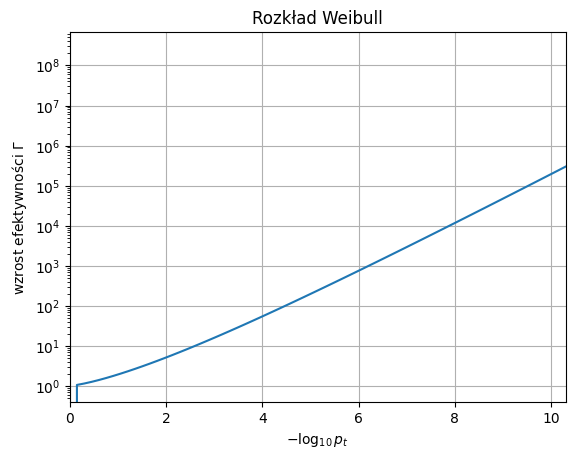

In [ ]:
# starting parameters
b = 2
mu = 1
dist = stats.weibull_min(c=b, scale=mu)


# by vectors
density = 100
x = np.linspace(0, 10, density)
p_t_list = np.array([10**(-i/(density/10)) for i in range(density)])
t_list = [t_from_p(p_t, b, mu) for p_t in p_t_list]
a_list = [opt_a(t, mu, b) for t in t_list]
W_list = [w_gen(a, b, mu) for a in a_list]
pdf_IS_list = [lambda x, a=a: dist.pdf(x/a) / a for a in a_list]
val_err = [simulation_gain_tail_kd(p_t, t, W, pdf_IS, 0, np.inf) for p_t, t, W, pdf_IS in zip(p_t_list, t_list, W_list, pdf_IS_list)]
y = [val for val, err in val_err]
error = max((err for val, err in val_err))
print(error)
plt.plot(x, y)
plt.yscale('log')
plt.xlim(0, 10.3)
plt.title('Rozkład Weibull')
plt.xlabel('$-\log_{10}p_t$')
plt.ylabel('wzrost efektywności $\Gamma$')
plt.grid()
plt.show()
# sprawdzone (znak ujemny wychodzi bo różnica powinna być w module)

# robimy tak: zgarniamy różne wartości p_t i na te wartości wrzucamy jak się zmienia sumulation gain to nam mówi ile więcej próbek trzeba by dac w mc by osiągnac takzą samą precyzje jak IS 

# robimy coś takiego: wybieramy coraz mniej prawdopodobne zdarzenia i spradzamy jak dla optymalnego a zwiększa się ilość próbek które potrzebujemy dobrać w metodzie monte carlo aby otrzymać podobne wyniki

rozkład normalny 

In [45]:
dist = stats.norm(loc=0, scale=1)


# by vectors
density = 100
# creating args
x = list(np.linspace(0.01, 10, density))
# probabilities to check 
p_t_list = [10**(-i) for i in x]
# finding t(quantile of 1-p_t value in normal distribution) values (to minimize a value)
t_list = [dist.ppf(1-p_t) for p_t in p_t_list]
# creating W values which depends only on a (derivation I(a) = E_*[(X >= t) * W**2(X)]) 
# finding optimal values for a IMPO
a_list = [minimize_scalar(lambda a: quad(lambda x: a * dist.pdf(x)**2/dist.pdf(x/a), t, t + 35)[0], bounds=[0, 10**3]).x for t in t_list]
# finding functions W
W_list = [fact_W_scaling(a, lambda x: dist.pdf(x)) for a in a_list]
# finding densities of IS f_*(x) = 1/a f(x/a)
pdf_IS_list = [lambda x, a=a: dist.pdf(x/a) / a for a in a_list]
# finding \Gamma function values 
val_err = [simulation_gain_tail_kd(p_t, t, W, pdf_IS, -np.inf, t+30) for p_t, t, W, pdf_IS in zip(p_t_list, t_list, W_list, pdf_IS_list)]
y = [val for val, err in val_err]

error = max((err for val, err in val_err))
print(error)



/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/3363037626.py:14: RuntimeWarning: invalid value encountered in scalar divide
  a_list = [minimize_scalar(lambda a: quad(lambda x: a * dist.pdf(x)**2/dist.pdf(x/a), t, t + 35)[0], bounds=[0, 10**3]).x for t in t_list]
/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/3363037626.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a_list = [minimize_scalar(lambda a: quad(lambda x: a * dist.pdf(x)**2/dist.pdf(x/a), t, t + 35)[0], bounds=[0, 10**3]).x for t in t_list]
/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/3363037626.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  a_list = [minimize_scalar(lambda a: quad(lambda x: a * dist.pdf(x)**2/dist.pdf(x/a), t, t + 35)[0], bounds=[0, 10**3]).x for t in t_list]


1.3930225623351705e-08


<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\G'
/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/1885056848.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$-\log_{10}p_t$')
/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/1885056848.py:7: SyntaxWarning: invalid escape sequence '\G'
  plt.ylabel('Wzrost efektywności $\Gamma$')


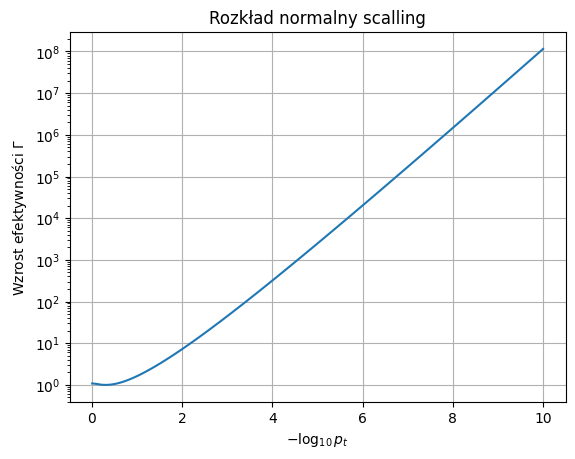

In [46]:
plt.plot(x, y)
plt.yscale('log')
# plt.ylim([0, 10**11])
# plt.xlim(0, 10.3)
plt.title('Rozkład normalny scalling')
plt.xlabel('$-\log_{10}p_t$')
plt.ylabel('Wzrost efektywności $\Gamma$')
plt.grid()
plt.show()

#### translation

basic functions to IS

In [26]:
# density function 
def fact_W_translation(c: float, f: callable) -> callable:
    '''Return W function of translation method of importance sampling'''
    return lambda x, c=c: f(x)/f(x-c)


In [39]:
# to musimy zaimplementować (to jest dobra )
minimize_scalar(lambda c: quad(lambda x: dist.pdf(x)**2/dist.pdf(x - c), t_list[30], t_list[30] + 35)[0], bounds=[0, 3*4]).x

np.float64(3.2654526900773533)

In [65]:
dist = stats.norm(loc=0, scale=1)

# by vectors
density = 100
# creating args
x = list(np.linspace(0.01, 10, density))
# probabilities to check 
p_t_list = [10**(-i) for i in x]
# finding t(quantile of 1-p_t value in normal distribution) values (to minimize a value)
t_list = [dist.ppf(1-p_t) for p_t in p_t_list]
# creating W values which depends only on a (derivation I(a) = E_*[(X >= t) * W**2(X)]) 
# finding optimal values for a IMPO
c_list = [minimize_scalar(lambda c: quad(lambda x: dist.pdf(x)**2/dist.pdf(x - c), t, t + 35)[0], bounds=[0, 100]).x for t in t_list]
# finding functions W
W_list = [fact_W_translation(c, lambda x: dist.pdf(x)) for c in c_list]
# finding densities of IS f_*(x) = 1/a f(x/a)
pdf_IS_list = [lambda x, c=c: dist.pdf(x - c) for c in c_list]
# finding \Gamma function values 
val_err = [simulation_gain_tail_kd(p_t, t, W, pdf_IS, -np.inf, c + 30) for p_t, t, W, pdf_IS, c in zip(p_t_list, t_list, W_list, pdf_IS_list, c_list)]
y = [val for val, err in val_err]

error = max((err for val, err in val_err))
print(error)




/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/2710824574.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  c_list = [minimize_scalar(lambda c: quad(lambda x: dist.pdf(x)**2/dist.pdf(x - c), t, t + 35)[0], bounds=[0, 100]).x for t in t_list]
/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/2710824574.py:13: RuntimeWarning: overflow encountered in scalar divide
  c_list = [minimize_scalar(lambda c: quad(lambda x: dist.pdf(x)**2/dist.pdf(x - c), t, t + 35)[0], bounds=[0, 100]).x for t in t_list]
/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/2710824574.py:13: RuntimeWarning: invalid value encountered in scalar divide
  c_list = [minimize_scalar(lambda c: quad(lambda x: dist.pdf(x)**2/dist.pdf(x - c), t, t + 35)[0], bounds=[0, 100]).x for t in t_list]
/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/2710824574.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the

nan


In [66]:
print(list(zip(t_list, c_list)))

[(np.float64(-1.9997658101835842), np.float64(38.196605067010616)), (np.float64(-0.7541616862020523), np.float64(38.196605067010616)), (np.float64(-0.28980950362884617), np.float64(38.196605067010616)), (np.float64(0.03331234536290301), np.float64(38.196605067010616)), (np.float64(0.29027938245396884), np.float64(38.196605067010616)), (np.float64(0.5077566256064416), np.float64(0.9524494250422566)), (np.float64(0.6985803420847285), np.float64(1.0965164689877556)), (np.float64(0.8700072572465791), np.float64(1.2318792073802947)), (np.float64(1.0265780448575976), np.float64(1.3597234505534632)), (np.float64(1.1713411989062967), np.float64(1.4810125743377773)), (np.float64(1.3064524319414748), np.float64(1.5965464975309394)), (np.float64(1.4334981928007275), np.float64(1.7069863486231949)), (np.float64(1.5536835518741239), np.float64(1.8128859305843847)), (np.float64(1.667947760363534), np.float64(1.9147119826007144)), (np.float64(1.7770386892560364), np.float64(2.012860912831199)), (np.f

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\G'
/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/3163167687.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$-\log_{10}p_t$')
/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/3163167687.py:7: SyntaxWarning: invalid escape sequence '\G'
  plt.ylabel('Wzrost efektywności $\Gamma$')


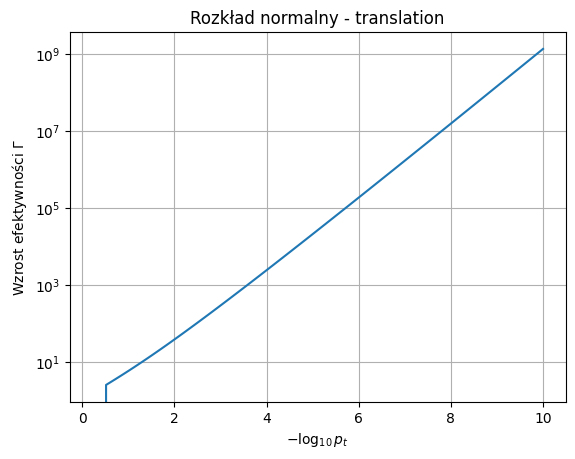

In [67]:
plt.plot(x, y)
plt.yscale('log')
# plt.ylim([0, 10**11])
# plt.xlim(0, 10.3)
plt.title('Rozkład normalny - translation')
plt.xlabel('$-\log_{10}p_t$')
plt.ylabel('Wzrost efektywności $\Gamma$')
plt.grid()
plt.show()

Rozkład Weibull

In [76]:
b = 2
mu = 1
dist = stats.weibull_min(c=b, scale=mu)

# by vectors
density = 100
# creating args
x = list(np.linspace(0.01, 10, density))
# probabilities to check 
p_t_list = [10**(-i) for i in x]
# finding t(quantile of 1-p_t value in normal distribution) values (to minimize a value)
t_list = [dist.ppf(1-p_t) for p_t in p_t_list]
# creating W values which depends only on a (derivation I(a) = E_*[(X >= t) * W**2(X)]) 
# important, we need to have bound till t because when we have bounds beyond we will get null values at begginigs and we always want to have density on it
c_list = [minimize_scalar(lambda c: quad(lambda x: dist.pdf(x)**2/dist.pdf(x - c), t, t + 15)[0], bounds=[0, t]).x for t in t_list]
# finding functions W
W_list = [fact_W_translation(c, lambda x: dist.pdf(x)) for c in c_list]
# finding densities of IS f_*(x) = 1/a f(x/a)
pdf_IS_list = [lambda x, c=c: dist.pdf(x - c) for c in c_list]
# finding \Gamma function values 
val_err = [simulation_gain_tail_kd(p_t, t, W, pdf_IS, -np.inf, t + 15) for p_t, t, W, pdf_IS, c in zip(p_t_list, t_list, W_list, pdf_IS_list, c_list)]
y = [val for val, err in val_err]

error = max((err for val, err in val_err))
print(error)




1.4465513168183258e-08


<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\G'
/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/1862676929.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$-\log_{10}p_t$')
/var/folders/fp/vddtjqvn2hzg1k4j1kvttxmw0000gp/T/ipykernel_11840/1862676929.py:7: SyntaxWarning: invalid escape sequence '\G'
  plt.ylabel('Wzrost efektywności $\Gamma$')


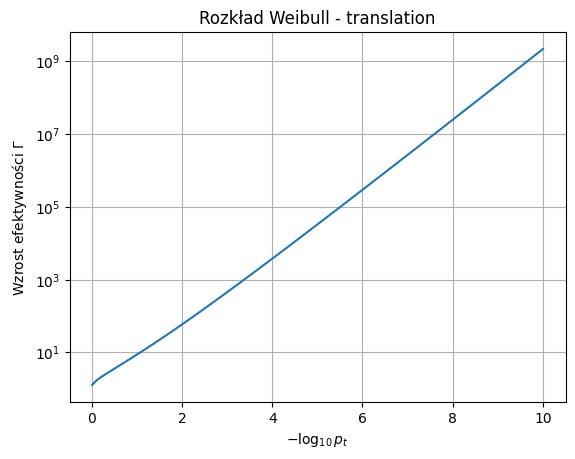

In [79]:
plt.plot(x, y)
plt.yscale('log')
# plt.ylim([0, 10**11])
# plt.xlim(0, 10.3)
plt.title('Rozkład Weibull - translation')
plt.xlabel('$-\log_{10}p_t$')
plt.ylabel('Wzrost efektywności $\Gamma$')
plt.grid()
plt.show()

example of calculating, they show it for normal distribution, (for every distribution we obtain something different how to generlize that problem)

In [ ]:
# we are taking same monte carlo estimate BUT on different probes !!!
# działa fest 


t, c, w, pdf, p = t_list[30], c_list[30], W_list[30], pdf_IS_list[30], p_t_list[30]

# from standartd distribution 
probe_MC = dist.rvs(1000000)
# distribtution is shifted 
probe_IS = dist.rvs(1000) + c

print(monte_carlo_estimate(probe_MC, t))
print(monte_carlo_estimate(probe_IS, t, lambda x: dist.pdf(x)/dist.pdf(x - c)))
print(p)

0.000904
0.0008669066910408149
0.0009177560850805837


### combine scaling and translation 